# SDOT Trees Data Exploration

Here are some of my current tasks with the dataset:

* Figure out the precise nature of the `x` and `y` coordinates.
* Figure out how  to superimpose the tree locations on top of a map of Seattle accurately.
* Create a new column to classify trees by their scientific name, but group very specific cultivars together.
* Identify any filterable data (e.g. there are trees with name "stump").
* Create a new column to indicate whether the tree species is indigenous.
* Learn about the pollenation radius of the indigenous trees. Is it different in urban areas?
* Identify areas which could use some more of any particular tree based on pollenation radii.
* Identify areas which have a lower indigeneous population.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('SDOT_Trees_CDL_20241119.csv', dtype={
    'CONDITION': 'string',
    'CONDITION_ASSESSMENT_DATE': 'string',
    'ASBUILTPLANNO': 'string',
})

df['CONDITION'] = df['CONDITION'].fillna('')
df['CONDITION_ASSESSMENT_DATE'] = df['CONDITION_ASSESSMENT_DATE'].fillna('')
df['ASBUILTPLANNO'] = df['ASBUILTPLANNO'].fillna('')

In [3]:
print(df.columns)

Index(['OBJECTID', 'COMPKEY', 'UNITID', 'UNITDESC', 'CONDITION',
       'CONDITION_ASSESSMENT_DATE', 'CURRENT_STATUS', 'PRIMARYDISTRICTCD',
       'SECONDARYDISTRICTCD', 'OVERRIDEYN', 'COMPTYPE', 'SEGKEY', 'UNITTYPE',
       'OWNERSHIP', 'CURRENT_STATUS_DATE', 'LAST_VERIFY_DATE', 'PLANTED_DATE',
       'BOTANICAL_NAME', 'SCIENTIFIC_NAME', 'HERITAGE', 'EXCEPTIONAL',
       'CODEREQ', 'GSI', 'GREEN_FACTOR', 'WIRES', 'CABLED',
       'CLEARANCE_PROBLEM', 'SPACETYPE', 'SITETYPE', 'GROWSPACE', 'DIAM',
       'CONDITION_RATING', 'FUNDING_SOURCE', 'WATER_THROUGH_YR1',
       'WATER_THROUGH_YR2', 'WATER_THROUGH_YR3', 'OWNERDIAM', 'EXPDATE',
       'COMMON_NAME', 'TREEHEIGHT', 'ASBUILTPLANNO', 'LANDSCAPEAREAASSOC',
       'COMMENTS', 'OVERRIDECOMMENT', 'SHAPE_LNG', 'SHAPE_LAT',
       'IRRIGATESYSYN', 'ASSETGROUPID', 'ASSETGROUPDESC', 'MODDATE',
       'TOTAL_RANK', 'TOTAL_COUNT', 'GENUS', 'UFMAINTMGMTUNIT', 'x', 'y'],
      dtype='object')


## Where Are These Trees?

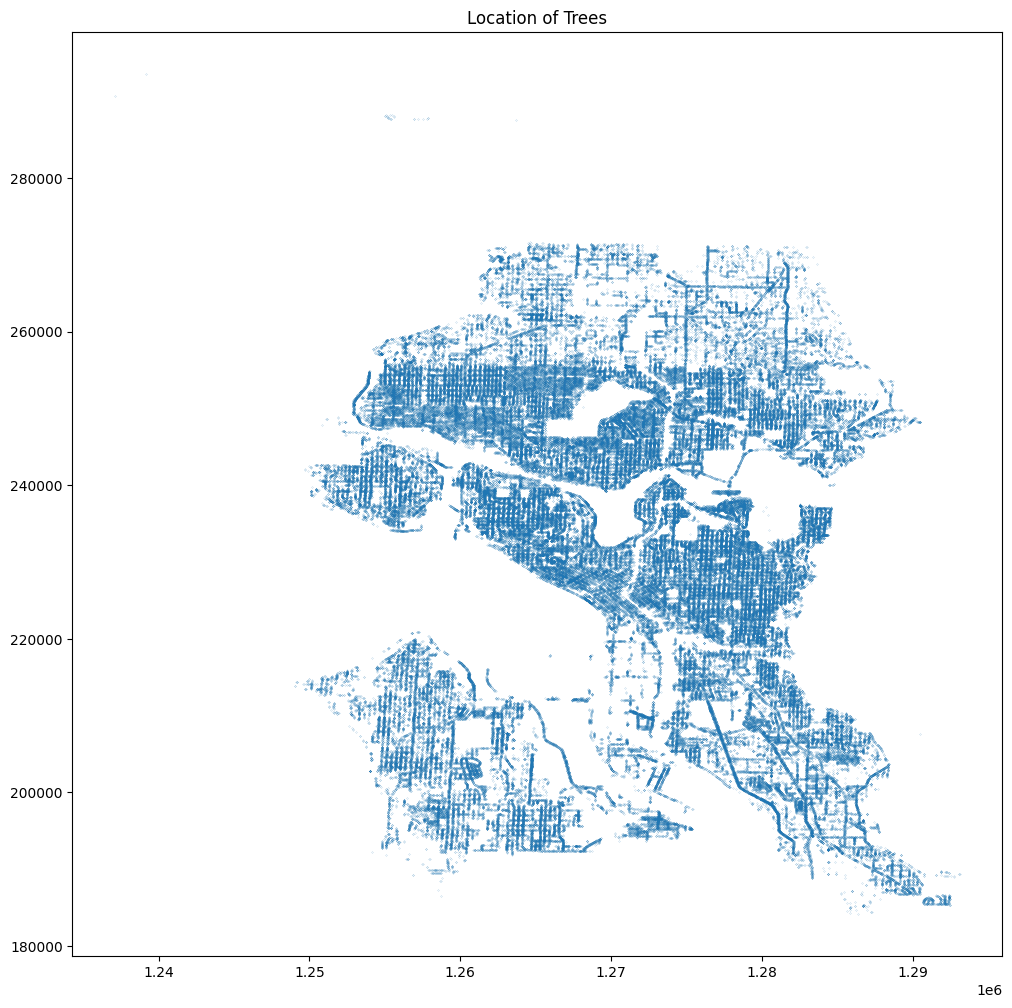

In [4]:
plt.figure(figsize=(12, 12))
plt.scatter(df['x'], df['y'], s=.01)
plt.title('Location of Trees')
plt.show()